In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, f1_score
import scipy.stats as stats
from scipy import io
import scipy.signal as signal


In [3]:
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
def import_data(file_path):
    return pd.read_csv(file_path)

In [4]:
def load_dreem(file_path):
    return io.loadmat(file_path)

In [5]:
def truncate_time(rcs_data):
    """Creates a column with a truncated time stamp hh:mm:ss. This matches the timestamp format of the dreem data"""
    rcs_data['MatchTime'] = ''
    rcs_data['MatchTime'] = rcs_data['localTime'].str.slice(12,20)

In [6]:
def match_index(rcs_data, dreem_data):
    """Creates a column in dreem_data that contains the index of the rcs_data with the corresponding timestamp.
        Only accepts a single recording epoch for rcs and dreem data."""

    dreem_data["RCS_Index"] = -1


    for i in range(dreem_data.shape[0]):
        index = np.min(rcs_data.index[rcs_data['MatchTime'] == dreem_data["Timehhmmss"].iloc[i]])
        if index >= 0:
            dreem_data["RCS_Index"].iloc[i] = int(index)

In [7]:
def label_rcs(rcs_data, dreem_data, interval=7500):
    """Labels the sleep stage of a time point in rcs_data using the corresponding timestamp in the dreem_data df.
        Assumes 250 Hz sample rate.
        Inputs: interval is the number of rows in RCS data frame that occur in 30 seconds."""
    rcs_data["SleepStage"] = -1

    for i in range(dreem_data.shape[0]):
        index = dreem_data["RCS_Index"].iloc[i]
        if index >= 0:
            rcs_data['SleepStage'].iloc[index:index+interval] = dreem_data["SleepStage"].iloc[i]


In [8]:
def label_beginning(rcs_data, dreem_data):
    """Only call if Dreem recording begins before rcs_data.
    This function will label the missing elements for the first unlabelled block of rcs data points."""
    dreem_tmp = np.min(np.where(dreem_data["RCS_Index"].values >= 0))
    rcs_tmp = np.min(np.where(rcs_data["SleepStage"] > 0))
    rcs_data["SleepStage"].iloc[0:rcs_tmp] = dreem_data["SleepStage"].iloc[dreem_tmp-1]


In [9]:
rcs_day_paths = [
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/4_12_21/Session1618291552302/DeviceNPC700398H/combinedDataTable.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/4_13_21/Session1618383275250/DeviceNPC700398H/combinedDataTable.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/4_14_21/Session1618466025554/DeviceNPC700398H/combinedDataTable.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/4_15_21/Session1618551933403/DeviceNPC700398H/combinedDataTable.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/4_16_21/Session1618641928594/DeviceNPC700398H/combinedDataTable.csv'
]

dreem_paths = [
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/4_12_21/hypnoCleaned.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/4_13_21/hypnoCleaned.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/4_14_21/hypnoCleaned.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/4_15_21/hypnoCleaned.csv',
    '/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/4_16_21/hypnoCleaned.csv'
]

In [10]:
rcs_days = []

for i in rcs_day_paths:
    rcs_days.append(import_data(i))

In [11]:
dreem_days = []

for i in dreem_paths:
    dreem_days.append(import_data(i))

In [12]:
## Only run this cell if looking at power data (ie not time series data)
for i in range(len(rcs_days)):
    print(len(rcs_days[i]))

# Note: The below code OVERRIDES the dataframe, only storing non-null power data time points
for i in range(len(rcs_days)):
    tmp = rcs_days[i]
    tmp = tmp[pd.notnull(tmp["Power_Band1"])]
    rcs_days[i] = tmp.reset_index().drop(columns=["index"]).copy()


for i in range(len(rcs_days)):
    print(len(rcs_days[i]))


8723525
6043496
7243606
6270975
5463390
16410
48174
57712
50155
43647


In [ ]:
rcs_days[1]

In [13]:
assert len(rcs_days) == len(dreem_days)

for i in range(len(rcs_days)):
    truncate_time(rcs_days[i])
    match_index(rcs_days[i], dreem_days[i])

/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
#################################################

In [14]:
for i in range(len(rcs_days)):
    label_rcs(rcs_days[i], dreem_days[i], interval=60)

In [15]:
def get_train_data(rcs_data, columns, num_days=4, label_column=-1, sleep_stage=1):
    """Right now, this function assumes we are classifying deep sleep.
        Inputs: list of RCS epochs as pandas dataframes, and corresponding columns for training.
        Outputs: Concatenated power data across days and corresponding 0-1 label for deep sleep."""

    X = rcs_data[0].iloc[:,columns].values
    y = rcs_data[0].iloc[:,label_column].values

    indices = np.where(y > 0)

    X = X[indices,:][0]
    y = y[indices]

    y[np.where(y != sleep_stage)] = 0
    y[np.where(y == sleep_stage)] = 1

    for i in range(1,num_days):
        tmpX = rcs_data[i].iloc[:,columns].values
        tmpy = rcs_data[i].iloc[:,label_column].values
        indices = np.where(tmpy > 0)

        tmpX = tmpX[indices,:]
        tmpy = tmpy[indices]
        tmpy[np.where(tmpy != sleep_stage)] = 0
        tmpy[np.where(tmpy == sleep_stage)] = 1

        X = np.concatenate((X, tmpX[0]), axis=0)
        y = np.concatenate((y, tmpy), axis=0)

    return X, y

In [16]:
def get_single_day_data(rcs_data, columns, day=4, label_column=-1, sleep_stage=1):
    """Returns data from single day, usually for using as a validation set
    Inputs: List of RCS pandas dataframes, columns for returning, and element in RCS list.
    Outputs: Corresponding data and 0-1 labels for deep sleep."""
    X_val = rcs_data[day].iloc[:, columns].values
    y_val = rcs_data[day].iloc[:, label_column].values
    y_val[np.where(y_val != sleep_stage)] = 0
    return X_val, y_val



In [17]:
def get_scores(predictions, y_val):
    print("Accuracy: " + str(accuracy_score(predictions, y_val)))
    print("F1: " + str(f1_score(y_val, predictions)))


In [ ]:
def train_bagged_svm(X, y, c=10, n_estimators=10, kernel='linear', max_samples_denominator=10, bootstrap=False):
    clf = BaggingClassifier(SVC(C=c, kernel=kernel), n_estimators=n_estimators,
                            max_samples = 1.0 / max_samples_denominator, bootstrap=bootstrap, verbose=True, n_jobs=-1)

    clf.fit(X, y)
    return clf



In [18]:
def average_block(data, block_size):
    """Takes in data array, and returns the average of blocks of the data array.
        Input: Data array (2 dim), block size.
        Output: Data array of size floor(Data array.shape[0] / block size). Where the reduction in size arises
        from averaging of blocks of data entries."""

    trunc = data.shape[0] % block_size
    if trunc > 0:
        data_r = data[:-1*trunc,:].reshape((-1,block_size,data.shape[-1]))
    else:
        data_r = data.reshape((-1,block_size,data.shape[-1]))
    return np.mean(data_r, axis = 1).reshape((-1,data.shape[-1]))


In [ ]:
rcs_days[0].iloc[0:10,11:19]

In [ ]:
##############################################

In [19]:
X,y = get_train_data(rcs_days, np.arange(15,17))

print(X.shape)
print(y.shape)

(171671, 2)
(171671,)


In [ ]:
clf = train_bagged_svm(X,y,c=1000,max_samples_denominator=500)

In [ ]:
## Maybe use distance to hyperplane as a predictive parameter
X_val = rcs_days[4].iloc[:,15:17].values

predictions = clf.predict(X_val)

y_val = rcs_days[4].iloc[:,-1].values
y_val[np.where(y_val != 1)] = 0

get_scores(predictions, y_val)


In [ ]:
np.sum(predictions==1)

In [ ]:
#################################
# LDA Attempt

In [20]:
def get_LD_parameters(clf_obj, fixedPointFactor=256, scale_factor=100):
    weights = clf_obj.coef_*scale_factor
    intercept = clf_obj.intercept_ * scale_factor
    subtract_vector = np.ones_like(weights) * (intercept/np.size(weights))
    subtract_vector = -1 * subtract_vector / weights
    weights = weights*fixedPointFactor
    return np.round(weights), np.round(subtract_vector)


In [21]:
def get_LD_parameters_2(clf_obj, fixedPointFactor=256, scale_factor=100):
    """This is the weights that would go directly into the RCS API.
        i.e. these weights account for (are scaled by) the FFPV"""
    weights = np.round(clf_obj.coef_*scale_factor*fixedPointFactor)
    weights_prime = weights/fixedPointFactor
    intercept = clf_obj.intercept_ * scale_factor
    subtract_vector = np.ones_like(weights) * (intercept/np.size(weights)) * -1
    subtract_vector = subtract_vector / weights_prime
    return weights, np.round(subtract_vector)


In [22]:
def get_LD_parameters_3(clf_obj, scale_factor=100):
    """Returns the weights that go into the adaptive_config.json.
        i.e. These weights do not account for (are not scaled by) the FFPV,
        thus assuming that this scaling is included automatically downstream."""
    weights = clf_obj.coef_*scale_factor
    intercept = clf_obj.intercept_ * scale_factor
    subtract_vector = np.ones_like(weights) * (intercept/np.size(weights)) * -1
    subtract_vector = subtract_vector / weights
    return weights, subtract_vector

In [27]:
def test_LD_parameters(val_data, val_labels, weights, sub_vec, FFPV=256, FFPV_scaled_weights=False):
    """Assumes second dimension of val_data matches size of weights and sub_vec"""
    if FFPV_scaled_weights:
        weights_ = weights / FFPV
    else:
        weights_ = weights

    predictions = np.sum(weights_ * (val_data - sub_vec), axis=1)
    print(np.count_nonzero(predictions == 0))
    print("1 :" + str(np.max(predictions[np.where(predictions > 0)])) + " ; " + str(np.min(predictions[np.where(predictions > 0)])))
    print("0 :" + str(np.max(predictions[np.where(predictions < 0)])) + " ; " + str(np.min(predictions[np.where(predictions < 0)])))


    predictions[np.where(predictions > 0)] = 1
    predictions[np.where(predictions < 0)] = 0
    get_scores(predictions, val_labels)



In [ ]:
def convert_to_unsigned(*args):
    """Only numpy arrays accepted as elements of args. Assumes 32 bit"""
    unsigned = []
    for i in args:
        unsigned.append(i.astype('uint32'))
    return unsigned

In [24]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [944]:
X,y = get_train_data(rcs_days, np.arange(15,17))



In [39]:
for i in rcs_days:
    print(i.iloc[0])

localTime                        12-Apr-2021 22:27:29.332
DerivedTime                                 1618291649332
TD_key0                                         -0.066701
TD_key1                                         -0.134415
TD_key2                                         -0.122678
TD_key3                                          0.007843
TD_samplerate                                         NaN
Power_ExternalValuesMask                              0.0
Power_FftSize                                       256.0
Power_IsPowerChannelOverrange                         0.0
Power_ValidDataMask                            11111111.0
Power_Band1                                         394.0
Power_Band2                                          69.0
Power_Band3                                           7.0
Power_Band4                                           1.0
Power_Band5                                         355.0
Power_Band6                                         997.0
Power_Band7   

In [945]:
print(np.mean(X[np.where(y==0)], axis=0))
print(np.mean(X[np.where(y==1)], axis=0))

[761.04553958 462.03079822]
[2186.29368504  339.37914297]


In [ ]:
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X,y)


In [ ]:
X_val = rcs_days[4].iloc[:,15:17].values
y_val = rcs_days[4].iloc[:,-1].values
y_val[np.where(y_val != 1)] = 0


In [ ]:
preds = clf_LDA.predict(X_val)
get_scores(preds, y_val)


In [ ]:
np.arange(10).reshape((5,2))

In [ ]:
print(average_block(np.arange(10).reshape((5,2)),2))
np.arange(5)[(2-1)::4]

In [31]:
np.shape(average_block(X,60))

(2861, 2)

In [35]:
X,y = get_train_data(rcs_days, np.arange(17,19), num_days=4)

In [37]:
for i in rcs_days:
    print(len(i))

16410
48174
57712
50155
43647


In [38]:
16410+48174+57712+50155


172451

In [36]:
X.shape

(171671, 2)

In [ ]:
for i in [1, 2, 5, 10, 20, 30, 60]:
    clf_LDA = LinearDiscriminantAnalysis(store_covariance=True)
    clf_LDA.fit(average_block(X, i),y[(i-1)::i])

    X_val = rcs_days[4].iloc[:,17:19].values
    y_val = rcs_days[4].iloc[:,-1].values
    y_val[np.where(y_val != 1)] = 0

    preds = clf_LDA.predict(average_block(X_val,i))
    print(i)
    get_scores(preds, y_val[(i-1)::i])


In [34]:
X.shape

(171671, 2)

In [30]:
clf_LDA.coef_

array([[0.01421282, 0.0014085 ]])

In [ ]:
acc = [0.77, 0.78, 0.79, .8, .82, .84, .87]
f1 = [.21, .28, .37, .44, .52, .56, .68]
num = [1, 2, 5, 10, 20, 30, 60]

ax = plt.figure(figsize=(10,10))
plt.plot(num, acc, label='Accuracy')
plt.plot(num, f1, label='F1')
plt.xlabel("Samples Averaged", size=20)
plt.xticks(size=20)
plt.ylabel("Score", size=20)
plt.yticks(size=20)
plt.legend()
plt.savefig('/Users/claysmyth/Desktop/score.png')
plt.show()


In [29]:
#Plot these

w1, sub1 = get_LD_parameters_3(clf_LDA)
print(w1)
print(sub1)

test_LD_parameters(ave, y_val[(i-1)::i], w1, sub1, FFPV_scaled_weights=False)

[[1.42128184 0.14085035]]
[[ 353.90848995 3571.19258947]]


NameError: name 'ave' is not defined

In [869]:
clf_LDA.priors_

array([0.88116043, 0.11883957])

In [953]:
X,y = get_train_data(rcs_days, np.arange(17,19), num_days=4)


for i in [1, 2, 5, 10, 20, 30, 60]:
    clf_LDA = LinearDiscriminantAnalysis(priors = [65, 45])
    clf_LDA.fit(average_block(X, i),y[(i-1)::i])

    X_val = rcs_days[4].iloc[:,17:19].values
    y_val = rcs_days[4].iloc[:,-1].values
    y_val[np.where(y_val != 1)] = 0

    preds = clf_LDA.predict(average_block(X_val,i))
    print(i)
    get_scores(preds, y_val[(i-1)::i])



/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",
/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",
/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",


1
Accuracy: 0.7936627946937934
F1: 0.4462616822429906
2
Accuracy: 0.8085964349539476
F1: 0.5110616879316399
5
Accuracy: 0.8239202657807309
F1: 0.577398955182843
10
Accuracy: 0.8414298808432631
F1: 0.6323060573857598
20
Accuracy: 0.8579285059578369
F1: 0.6784232365145227
30
Accuracy: 0.8672627235213205
F1: 0.7088989441930619
60
Accuracy: 0.9023383768913342
F1: 0.7867867867867868


/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",
/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",
/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",
/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:527: UserWarning: The priors do not sum to 1. Renormalizing
  warnings.warn("The priors do not sum to 1. Renormalizing",


In [883]:
w1, sub1 = get_LD_parameters_3(clf_LDA)
print(w1)
print(sub1)


[[1.42128184 0.14085035]]
[[ 296.36393799 2990.5264473 ]]


In [ ]:
w2, sub2 = get_LD_parameters_2(clf_LDA)
print(w2)
print(sub2)

test_LD_parameters(ave, y_val[(i-1)::i], w2, sub2, FFPV_scaled_weights=True)

In [ ]:
u_weights, u_sub = convert_to_unsigned(weights,sub)
print(u_weights)
print(u_sub)

In [ ]:
np.count_nonzero(np.arange(10) == 5)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_val, preds).ravel()

In [955]:
tmp_simon_test = average_block(X, 60)
tmp_simon_labels = y[(60-1)::60]



In [969]:
print(clf_LDA.covariance_)

[[40219.36510711 -6015.09088198]
 [-6015.09088198  8142.40692306]]


In [958]:
print(np.mean(tmp_simon_test[np.where(tmp_simon_labels == 0)], axis=0))
print(np.mean(tmp_simon_test[np.where(tmp_simon_labels == 1)], axis=0))


[268.07038873 208.666627  ]
[831.62259804 134.59205882]


In [ ]:
# TODO: 1) Online: Run narrow band, predict weights for beta+delta combination. Hopefully run detection overnight.
#   2) Offline power band calculation: Find best detection method (SVM vs LDA) + (what combination of channels/powerbands.
#   Calculate inferred bands)

# Figure out channel mapping

In [ ]:
#############################

In [947]:

deep = X[np.where(y==1),:][0]
non_deep = X[np.where(y==0),:][0]


<function matplotlib.pyplot.show(close=None, block=None)>

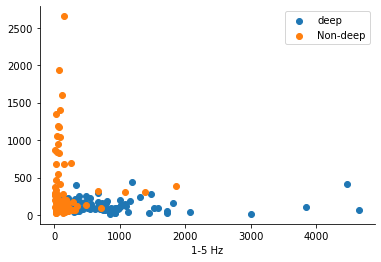

In [948]:
np.random.seed(10)
rand_ind = np.random.choice(len(deep), 100, replace=False)

plt.scatter(deep[rand_ind,0], deep[rand_ind,1], label='deep')
plt.scatter(non_deep[rand_ind,0], non_deep[rand_ind,1], label='Non-deep')
plt.xlabel("1-5 Hz")
plt.ylabel("")
plt.legend()
plt.show

In [949]:
plt.scatter(deep[rand_ind,1], deep[rand_ind,2], label='deep')
plt.scatter(non_deep[rand_ind,1], non_deep[rand_ind,2], label='Non-deep')
plt.legend()
plt.show

IndexError: index 2 is out of bounds for axis 1 with size 2

In [ ]:
plt.scatter(deep[rand_ind,2], deep[rand_ind,3], label='deep')
plt.scatter(non_deep[rand_ind,2], non_deep[rand_ind,3], label='Non-deep')
plt.legend()
plt.show

In [ ]:
rcs_days[0].iloc[0:20]

In [950]:
#################
ave = average_block(X_val,i)
y_ave_val = y_val[(i-1)::i]

In [951]:
deep = ave[np.where(y_ave_val==1),:][0]
non_deep = ave[np.where(y_ave_val==0),:][0]

In [ ]:
np.random.seed(10)
rand_ind_deep = np.random.choice(np.count_nonzero(y_ave_val==1), 200, replace=False)
rand_ind_non_deep = np.random.choice(np.count_nonzero(y_ave_val==0), 400, replace=False)

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(deep[:,0], deep[:,1], label='deep', s=5)
plt.scatter(non_deep[:,0], non_deep[:,1], label='Non-deep', s=5)
plt.legend()

x1 = np.arange(620,720)
x2 = -1*(w1[0,0] * x1 + intercept) / w1[0,1]

#test understanding of hyperplane. i.e. compare all predicted points to
# equation of hyperplane and verify that predictions are correct

plt.plot(x1,x2, color='k')

plt.xlabel("Delta Power", size=20)
plt.xticks(size=20)
plt.ylabel("Beta Power", size=20)
plt.title("Validation Classification", size=25)
plt.yticks(size=20)
plt.legend()
plt.savefig('/Users/claysmyth/Desktop/val.png')
plt.show()

In [ ]:
place = 0

for i in range(4):
    X_tmp = average_block(rcs_days[i].iloc[:,17:19].values,60)
    y_tmp = rcs_days[i].iloc[:,-1].values[59::60]

    deep = np.where(y_tmp==1)
    non_deep = np.where(y_tmp>1)

    plt.figure(figsize=(10,10))
    plt.scatter(X_tmp[deep,0], X_tmp[deep,1], label='deep', s=5)
    plt.scatter(X_tmp[non_deep,0], X_tmp[non_deep,1], label='Non-deep', s=5)

    x1 = np.arange(620,720)
    x2 = -1*(w1[0,0] * x1 + intercept) / w1[0,1]

    #test understanding of hyperplane. i.e. compare all predicted points to
    # equation of hyperplane and verify that predictions are correct

    plt.plot(x1,x2, color='k')

    plt.xlabel("Delta Power", size=20)
    plt.xticks(size=20)
    plt.ylabel("Beta Power", size=20)
    name = "Day " + str(i)
    plt.title(name, size=25)
    plt.yticks(size=20)
    plt.legend()
    plt.savefig('/Users/claysmyth/Desktop/train' + str(i) + '.png')
    plt.show()


In [ ]:
y_tmp

In [ ]:
ave

In [ ]:
test = ave @ w1[0] + intercept
test[np.where(test <= 0)] = 0
test[np.where(test>0)] = 1

In [ ]:
np.array_equal(test,preds)

###########################################

In [ ]:
june16rcs = import_data('/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/6_16_21/Session1623830150907/DeviceNPC700398H/combinedDataTable.csv')
june16Dreem = import_data('/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/6_16_21/hypnoCleaned.csv')

In [780]:
june16rcs.iloc[-1]


localTime                                         16-Jun-2021 04:07:52.075
DerivedTime                                                  1623841672075
TD_key0                                                                NaN
TD_key1                                                                NaN
TD_key2                                                                NaN
TD_key3                                                                NaN
TD_samplerate                                                          NaN
Power_ExternalValuesMask                                               0.0
Power_FftSize                                                        256.0
Power_IsPowerChannelOverrange                                          0.0
Power_ValidDataMask                                             11111111.0
Power_Band1                                                          198.0
Power_Band2                                                           76.0
Power_Band3              

In [ ]:
tmp = june16rcs
tmp = tmp[pd.notnull(tmp["Power_Band1"])]
june16rcs = tmp.reset_index().drop(columns=["index"]).copy()

truncate_time(june16rcs)
match_index(june16rcs, june16Dreem)

label_rcs(june16rcs, june16Dreem, interval=60)

In [779]:
np.min(june16rcs["SleepStage"].iloc[33:].values)

1

10572


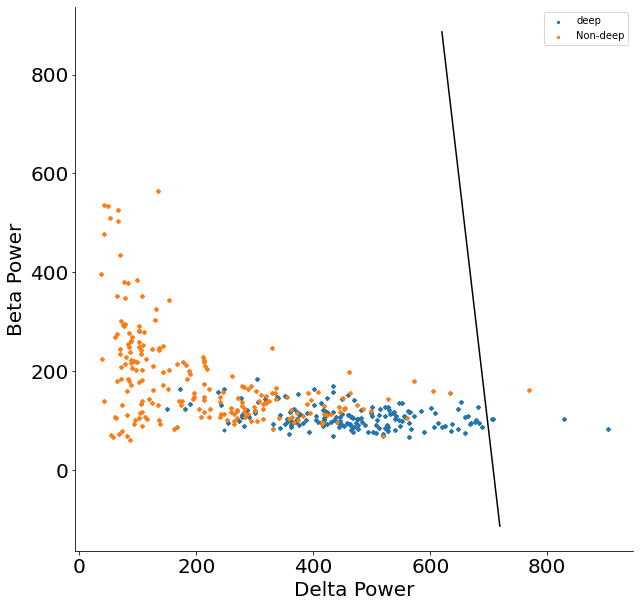

In [862]:
# ave2 = average_block(june16rcs.iloc[48:,17:19].values, 60)
#
# #ave2 = np.unique(june16rcs["Adaptive_Ld0_output"])
#
# labels = june16rcs["SleepStage"].values[48::60][:-1]

features = june16rcs.iloc[:,33:35].values

nd = np.where(labels == 0)
d = np.where(labels == 1)
print(np.size(d))

pred_nd = np.where(june16rcs['Adaptive_CurrentAdaptiveState'].values == 'State 3')

plt.figure(figsize=(10,10))
plt.scatter(features[d,0], features[d,1], label='deep', s=5)
plt.scatter(features[nd,0], features[nd,1], label='Non-deep',s=5)

x1 = np.arange(620,720)
x2 = -1*(w1[0,0] * x1 + intercept) / w1[0,1]

#test understanding of hyperplane. i.e. compare all predicted points to
# equation of hyperplane and verify that predictions are correct

plt.plot(x1,x2, color='k')

plt.xlabel("Delta Power", size=20)
plt.xticks(size=20)
plt.ylabel("Beta Power", size=20)

plt.yticks(size=20)
plt.legend()
plt.savefig('/Users/claysmyth/Desktop/test.png')
plt.show()

# Make a plot for each day...

10572


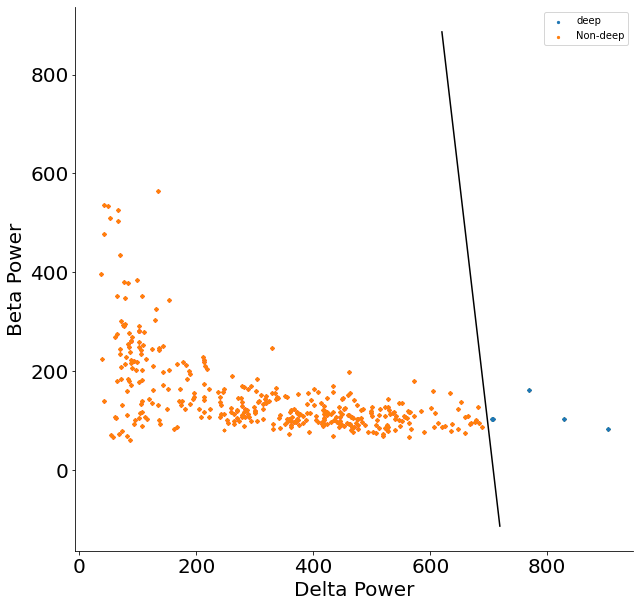

In [861]:
features = june16rcs.iloc[:,33:35].values

nd = np.where(labels == 0)
d = np.where(labels == 1)
print(np.size(d))

pred_nd = np.where(june16rcs['Adaptive_CurrentAdaptiveState'].values == 'State 3')
pred_d = np.where(june16rcs['Adaptive_CurrentAdaptiveState'].values == 'State 4')

plt.figure(figsize=(10,10))
plt.scatter(features[pred_d,0], features[pred_d,1], label='deep', s=5)
plt.scatter(features[pred_nd,0], features[pred_nd,1], label='Non-deep',s=5)

x1 = np.arange(620,720)
x2 = -1*(w1[0,0] * x1 + intercept) / w1[0,1]

#test understanding of hyperplane. i.e. compare all predicted points to
# equation of hyperplane and verify that predictions are correct

plt.plot(x1,x2, color='k')

plt.xlabel("Delta Power", size=20)
plt.xticks(size=20)
plt.ylabel("Beta Power", size=20)

plt.yticks(size=20)
plt.legend()
plt.savefig('/Users/claysmyth/Desktop/test.png')
plt.show()


In [ ]:
np.sum(june16rcs['Adaptive_Ld0DetectionStatus'] == 0) / len(june16rcs)

In [ ]:
plt.figure(figsize=(10,10))
bar = [np.sum(june16rcs['Adaptive_Ld0DetectionStatus'] == 101) / len(june16rcs), np.sum(june16rcs['Adaptive_Ld0DetectionStatus'] == 0) / len(june16rcs)]
plt.bar([0, -1], bar, tick_label=['low','None'])
plt.ylabel("Percent", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.title('LD0 Detector Readout', size=25)
plt.savefig('/Users/claysmyth/Desktop/bar.png')
plt.show()


In [ ]:
# Plot points and LD boundary
# Get accuracy scores

In [761]:
june16rcs['SleepStage'].iloc[np.where(june16rcs['Adaptive_CurrentAdaptiveState'].values == 'State 3')].values

array([-1, -1, -1, ...,  1,  1,  1])

In [758]:
predictions = np.zeros_like(june16rcs['SleepStage'].values)

predictions[np.where(june16rcs['Adaptive_CurrentAdaptiveState'].values == 'State 4')] = 1

labels = np.zeros_like(predictions)

labels[np.where(june16rcs['SleepStage'] == 1)] = 1

In [759]:
get_scores(predictions, labels)

Accuracy: 0.544905197705478
F1: 0.0439701959341367


In [760]:
np.unique(june16rcs['Adaptive_CurrentAdaptiveState'].values)


array(['State 3', 'State 4'], dtype=object)

In [826]:
np.count_nonzero(june16rcs['SleepStage'].values == 1)


10572

In [885]:
np.min(np.where(june16rcs['Adaptive_CurrentAdaptiveState'].values == 'State 4'))

7128

In [770]:
# Why the -1 SleepStage when a label should exist (fixed)
# Why ~22000 datapoints
    # Hours * min * second * 2. (2 because FFT interval is 500 ms)
# Do LD inputs (ie power values) make sense?
    # Yes
# Does LD output make sense?
    # Yes, see graphs above
# Is it comparing appropriately to threshold?
# Does adaptive state take previous 60 at every 500ms interval, or does it only change every 60 iterations of the FFT
    # (ie every 30 seconds)
    # Answer: Every 30 seconds, or every 60 FFT points (Slide 25 in PP)
# How to plot? Probably can't plot every datapoint because then I'm showing unaveraged data

# June 29, why so many NaN for Adaptive State?


14400

In [886]:
june16rcs.iloc[7128,33:35]

Adaptive_Ld0_featureInputs_1    708.0
Adaptive_Ld0_featureInputs_2    104.0
Name: 7128, dtype: object

In [857]:
june16rcs.iloc[1]



localTime                                         16-Jun-2021 00:57:25.575
DerivedTime                                                  1623830245575
TD_key0                                                          -0.076354
TD_key1                                                          -0.146179
TD_key2                                                          -0.090497
TD_key3                                                           0.020042
TD_samplerate                                                          NaN
Power_ExternalValuesMask                                               0.0
Power_FftSize                                                        256.0
Power_IsPowerChannelOverrange                                          0.0
Power_ValidDataMask                                             11111111.0
Power_Band1                                                         1700.0
Power_Band2                                                           50.0
Power_Band3              

In [907]:
june29rcs = import_data('/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/6_29_21/Session1624949468199/DeviceNPC700398H/combinedDataTable.csv')

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
      dtype=object)

In [908]:
ind = np.where(june29rcs["Adaptive_CurrentAdaptiveState"].notna())

In [914]:
june29rcs = 0




In [12]:
july1dreem = import_data("/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/7_1_21/hypnoCleaned.csv")


In [150]:
july1rcs = import_data('/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/7_1_21/Session1625120166750/DeviceNPC700398H/combinedDataTable.csv')

/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (19,27) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [151]:
# tmp = july1rcs
# tmp = tmp[pd.notnull(tmp["Power_Band1"])]
# july1rcs = tmp.reset_index().drop(columns=["index"]).copy()

truncate_time(july1rcs)
match_index(july1rcs, july1dreem)

label_rcs(july1rcs, july1dreem)

/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [929]:
july1rcs.iloc[99]

localTime                                         30-Jun-2021 23:18:34.528
DerivedTime                                                  1625120314528
TD_key0                                                          -0.038068
TD_key1                                                          -0.106094
TD_key2                                                           -0.07473
TD_key3                                                           0.034094
TD_samplerate                                                          NaN
Power_ExternalValuesMask                                               0.0
Power_FftSize                                                        256.0
Power_IsPowerChannelOverrange                                          0.0
Power_ValidDataMask                                             11111111.0
Power_Band1                                                          272.0
Power_Band2                                                          166.0
Power_Band3              

In [939]:
july1rcs.Adaptive_CurrentAdaptiveState.unique()

array(['State 0', 'State 3', 'State 4', nan], dtype=object)

In [971]:
july1rcs.iloc[0]

localTime                                         30-Jun-2021 23:17:45.028
DerivedTime                                                  1625120265028
TD_key0                                                          -0.079607
TD_key1                                                          -0.147486
TD_key2                                                          -0.091685
TD_key3                                                            0.01721
TD_samplerate                                                          NaN
Power_ExternalValuesMask                                               0.0
Power_FftSize                                                        256.0
Power_IsPowerChannelOverrange                                          0.0
Power_ValidDataMask                                             11111111.0
Power_Band1                                                           42.0
Power_Band2                                                           30.0
Power_Band3              

In [976]:
july1_labels = np.zeros(len(july1rcs))
july1_labels[np.where(july1rcs["SleepStage"].values == 1)] = 1

In [977]:
LD0_july1_predictions = np.zeros_like(july1_labels)
LD0_july1_predictions[np.where(july1rcs["Adaptive_CurrentAdaptiveState"].values == "State 4")] = 1

In [978]:
get_scores(LD0_july1_predictions, july1_labels)

Accuracy: 0.9442279153960307
F1: 0.7191657086549516


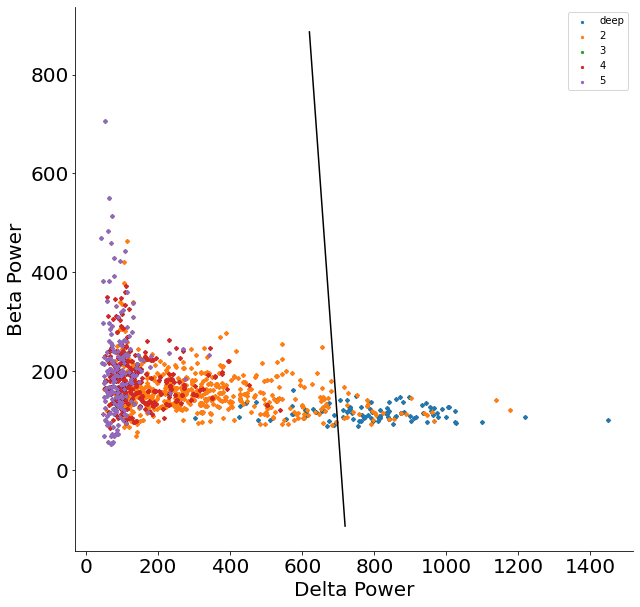

In [982]:
features = july1rcs.iloc[:,33:35].values

nd = np.where(july1_labels == 0)
d = np.where(july1_labels == 1)
#print(np.size(d))

#pred_nd = np.where(july1rcs['Adaptive_CurrentAdaptiveState'].values == 'State 3')

plt.figure(figsize=(10,10))
plt.scatter(features[d,0], features[d,1], label='deep', s=5)
plt.scatter(features[np.where(july1rcs['SleepStage'] == 2),0], features[np.where(july1rcs['SleepStage'] == 2),1], label='2',s=5)
plt.scatter(features[np.where(july1rcs['SleepStage'] == 3),0], features[np.where(july1rcs['SleepStage'] == 3),1], label='3',s=5)
plt.scatter(features[np.where(july1rcs['SleepStage'] == 4),0], features[np.where(july1rcs['SleepStage'] == 4),1], label='4',s=5)
plt.scatter(features[np.where(july1rcs['SleepStage'] == 5),0], features[np.where(july1rcs['SleepStage'] == 5),1], label='5',s=5)

x1 = np.arange(620,720)
x2 = -1*(w1[0,0] * x1 + intercept) / w1[0,1]

#test understanding of hyperplane. i.e. compare all predicted points to
# equation of hyperplane and verify that predictions are correct

plt.plot(x1,x2, color='k')

plt.xlabel("Delta Power", size=20)
plt.xticks(size=20)
plt.ylabel("Beta Power", size=20)

plt.yticks(size=20)
plt.legend()
plt.savefig('/Users/claysmyth/Desktop/test1.png')
plt.show()

In [173]:
###########################################
july2_rcs = import_data("/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/RCS02L/7_2_21/Session1625208847952/DeviceNPC700398H/combinedDataTable.csv")
july2_dreem = import_data("/Users/claysmyth/Desktop/Starr/RCS_Hypno_Data/DREEM/Patient_RCS02/7_2_21/hypnoCleaned.csv")

In [172]:
doop = "deep"

In [158]:
truncate_time(july2_rcs)
match_index(july2_rcs, july2_dreem)

label_rcs(july2_rcs, july2_dreem)


/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [92]:
july1_trunc = july1rcs.iloc[0:3600000]

In [71]:
sleep_props = np.zeros((3,4))

for i in range(1,5):
    sleep_props[0,i-1] = np.count_nonzero(july1rcs["SleepStage"].values == i) / np.count_nonzero((july1rcs["SleepStage"].values > 0) & (july1rcs["SleepStage"].values < 5))
    sleep_props[1,i-1] = np.count_nonzero(july2_rcs["SleepStage"].values == i) /  np.count_nonzero(july2_rcs["SleepStage"].values > 0 & (july2_rcs["SleepStage"].values < 5))
    sleep_props[2,i-1] = np.count_nonzero(july1_trunc["SleepStage"].values == i) / np.count_nonzero(july1_trunc["SleepStage"].values > 0 & (july1_trunc["SleepStage"].values < 5))

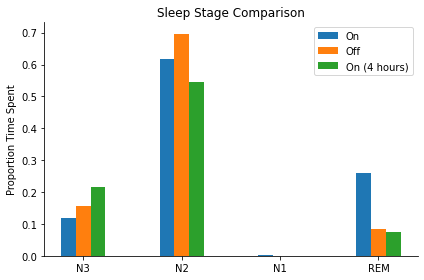

In [147]:
labels = ['N3', 'N2', 'N1', 'REM']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, sleep_props[0], width, label='On')
rects2 = ax.bar(x, sleep_props[1], width, label='Off')
rects3 = ax.bar(x + width, sleep_props[2], width, label='On (4 hours)')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion Time Spent')
ax.set_title('Sleep Stage Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.savefig("/Users/claysmyth/Desktop/sleep_stage.pdf")
plt.show()

In [33]:
sleep_props

array([[8.04251968e-04, 4.14619219e-03, 1.56165431e-05, 1.74905282e-03],
       [1.24604578e-03, 5.58088109e-03, 0.00000000e+00, 6.66897741e-04],
       [1.71666667e-03, 4.36666667e-03, 0.00000000e+00, 6.00000000e-04]])

In [23]:
np.unique(july1rcs["SleepStage"].values)

array([-1,  1,  2,  3,  4,  5])

In [25]:
for i in range(1,5):
    print(i)

1
2
3
4


In [35]:
np.count_nonzero(july2_rcs["SleepStage"].values > 0) / len(july2_rcs)

0.008002772890606833

In [ ]:

periodograms = np.zeros((5,1251))

In [140]:
for i in range(len(july1rcs)):
    if july1rcs["SleepStage"].values[i] == -1:
        july1rcs["SleepStage"].values[i] = july1rcs["SleepStage"].values[i-1]

In [143]:
for i in range(len(july2_rcs)):
    if july2_rcs["SleepStage"].values[i] == -1:
        july2_rcs["SleepStage"].values[i] = july2_rcs["SleepStage"].values[i-1]

In [141]:
july1_trunc = july1rcs.iloc[0:3600000]


In [59]:
sleep_list = ["N3", "N2"]

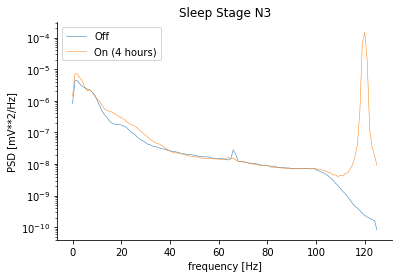

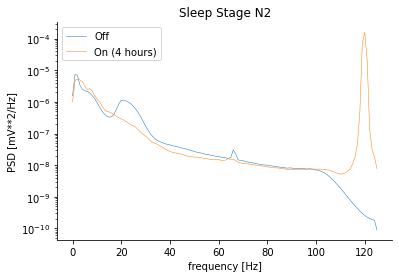

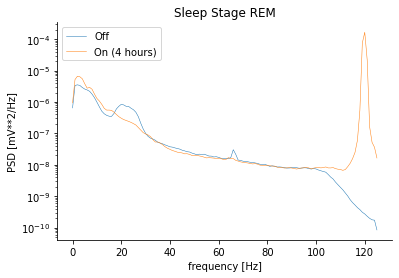

In [159]:
sample_rate = 250
for i in [1,2,4]:

    periodograms = []

    f, Pxx_den = signal.welch(july1rcs['TD_key1'].loc[july1rcs["SleepStage"].values == i].dropna(), fs=sample_rate, nperseg=250, noverlap=25)
    periodograms.append(Pxx_den)

    f, Pxx_den = signal.welch(july2_rcs['TD_key1'].loc[july2_rcs["SleepStage"].values == i].dropna(), fs=sample_rate, nperseg=250, noverlap=25)
    periodograms.append(Pxx_den)

    f, Pxx_den = signal.welch(july1_trunc['TD_key1'].loc[july1_trunc["SleepStage"].values == i].dropna(), fs=sample_rate, nperseg=250, noverlap=25)
    periodograms.append(Pxx_den)

    plt.figure()
    # plt.semilogy(f, periodograms[0], label="On", linewidth=0.5)
    plt.semilogy(f, periodograms[1], label="Off", linewidth=0.5)
    plt.semilogy(f, periodograms[2], label="On (4 hours)", linewidth=0.5)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [mV**2/Hz]')
    plt.legend()
    if i < 4:
        plt.title("Sleep Stage %s"%sleep_list[i-1])
    else:
        plt.title("Sleep Stage REM")
    plt.savefig("/Users/claysmyth/Desktop/Sleep_Stage_"+str(i))
    plt.show()

In [54]:

july1rcs['TD_key3'].isna().sum()

24250

In [84]:
import matplotlib.colors as colors

In [91]:
label_beginning(july1rcs, july1dreem)

/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [137]:
f, t, Sxx = signal.spectrogram(july2_rcs["TD_key3"].dropna().values, sample_rate, nperseg=250, noverlap=50)

In [126]:
sleep_list=["N3", "N2", "N1", "REM", "Awake"]

In [138]:
sleep_stage_interp = july2_rcs["SleepStage"].values[200::200]
for i in range(len(sleep_stage_interp)):
    if sleep_stage_interp[i] == -1:
        sleep_stage_interp[i] = sleep_stage_interp[i-1]

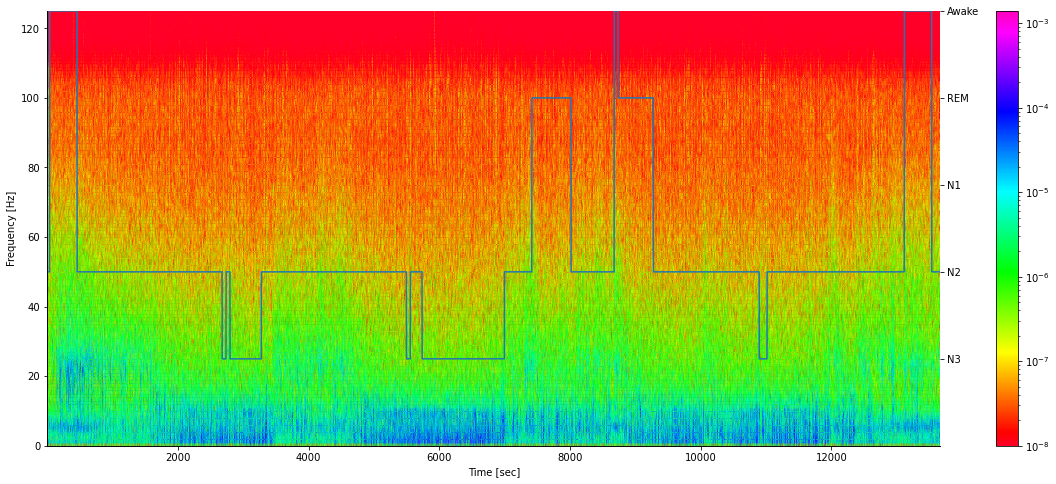

In [139]:
fig1 = plt.figure(figsize=(20,8))
ax1 = fig1.add_subplot(111)
tmp = Sxx
tmp[np.where(tmp < 1e-8)] = 1e-8

mesh = ax1.pcolormesh(t, f, tmp, shading='gouraud', norm=colors.LogNorm(vmin=Sxx.min(), vmax=Sxx.max()), cmap='gist_rainbow')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlabel('Time [sec]')
fig1.colorbar(mesh)

ax2 = ax1.twinx()
line = ax2.plot(t,sleep_stage_interp[:17081]*10)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(0,50)
ax2.set_yticks(np.arange(10,60,10))
ax2.set_yticklabels(sleep_list)

plt.savefig("/Users/claysmyth/Desktop/Spec_Off_cortex")
plt.show()



In [148]:
np.count_nonzero(july1rcs["SleepStage"].values == 1)

765119

In [149]:
# Why were most labels -1?????
# Please figure out and clean...

In [163]:

july1rcs["SleepStage"].iloc[0:60]

0     5
1     5
2     5
3     5
4     5
5     5
6     5
7     5
8     5
9     5
10    5
11    5
12    5
13    5
14    5
15    5
16    5
17    5
18    5
19    5
20    5
21    5
22    5
23    5
24    5
25    5
26    5
27    5
28    5
29    5
30    5
31    5
32    5
33    5
34    5
35    5
36    5
37    5
38    5
39    5
40    5
41    5
42    5
43    5
44    5
45    5
46    5
47    5
48    5
49    5
50    5
51    5
52    5
53    5
54    5
55    5
56    5
57    5
58    5
59    5
Name: SleepStage, dtype: int64

In [162]:
label_beginning(july1rcs, july1dreem)

/opt/anaconda3/envs/sleep_class/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [164]:
july1rcs.iloc[0]

localTime                                         30-Jun-2021 23:17:44.676
DerivedTime                                                  1625120264676
TD_key0                                                           -0.05271
TD_key1                                                           -0.11971
TD_key2                                                          -0.084881
TD_key3                                                           0.025598
TD_samplerate                                                          NaN
Power_ExternalValuesMask                                               NaN
Power_FftSize                                                          NaN
Power_IsPowerChannelOverrange                                          NaN
Power_ValidDataMask                                                    NaN
Power_Band1                                                            NaN
Power_Band2                                                            NaN
Power_Band3              

In [170]:
july1dreem["Timehhmmss"].iloc[0]

'23:10:59'